In [4]:
import numpy as np
from scipy.fft import rfftfreq, irfft
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


class NoiseGenerator:
    def __init__(self, sampling_frequency, trace_samples, noise_power, noise_type='white', noise_path=None):
        self.sampling_frequency = sampling_frequency
        self.trace_samples = trace_samples
        self.noise_power = noise_power
        self.noise_type = noise_type.lower()
        self.noise_path = noise_path

        self._spectra = {}
        self._normalize = {}
        self._setup_spectra()

    def _setup_spectra(self):
        # Define analytic spectra and normalizations
        self._spectra = {
            'white': lambda f: np.ones_like(f),
            'pink': lambda f: 1.0 / np.where(f == 0, np.inf, f),
            'blue': lambda f: f,
            'violet': lambda f: f ** 2,
            'brownian': lambda f: 1.0 / np.where(f == 0, np.inf, f ** 2)
        }

        self._normalize = {
            'white': lambda f: 1.0 / (np.max(f) - np.min(f)),
            'pink': lambda f: 1.0 / (np.log(np.max(f)) - np.log(np.sort(f)[1])),
            'blue': lambda f: 2.0 / (np.max(f)**2 - np.min(f)**2),
            'violet': lambda f: 3.0 / (np.max(f)**3 - np.min(f)**3),
            'brownian': lambda f: 1.0 / (1.0 / np.sort(f)[1] - 1.0 / np.max(f)),
        }

        if self.noise_type == 'custom':
            if self.noise_path is None:
                raise ValueError("Custom noise type requires a PSD file path.")
            psd_data = np.load(self.noise_path)
            self._spectra['custom'] = interp1d(psd_data[0], psd_data[1],
                                               fill_value=(psd_data[1][0], psd_data[1][-1]),
                                               bounds_error=False)
            self._normalize['custom'] = lambda f: np.ones_like(f)

    def spectrum(self, f):
        return self._spectra[self.noise_type](f)

    def generate_noise(self):
        N = self.trace_samples
        fs = self.sampling_frequency
        f = rfftfreq(N, d=1.0 / fs)

        norm = 0.5 * self.noise_power * self._normalize[self.noise_type](f) * fs * N
        psd = norm * self.spectrum(f)

        if self.noise_type == 'custom':
            psd /= (0.5 * self.noise_power)
            psd[1:N//2 + 1 - (N + 1) % 2] *= 0.5  # Halve non-DC Nyquist if even

        psd = np.sqrt(psd)

        # Generate random phase
        phi = np.random.uniform(0, 2 * np.pi, len(psd))
        phi[0] = 0  # DC component must be real
        if N % 2 == 0:
            phi[-1] = 0  # Nyquist component must also be real for even-length FFT

        # Create spectrum and transform to time domain
        spectrum = psd * np.exp(1j * phi)
        noise = irfft(spectrum)

        # Normalize time-domain power
        noise *= np.sqrt(self.noise_power) / np.std(noise)

        return noise



Analyzing: white


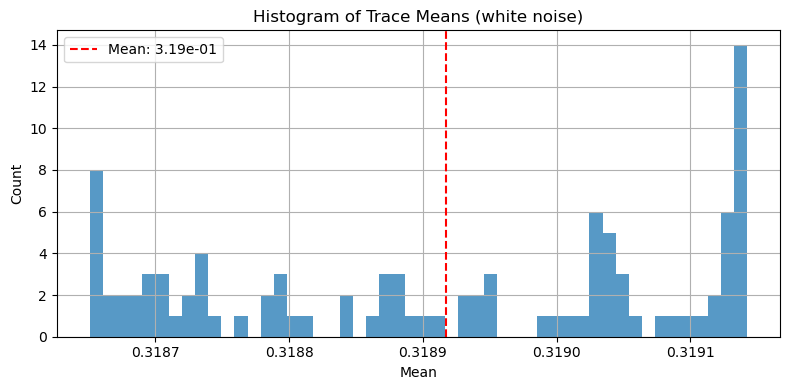


Analyzing: violet


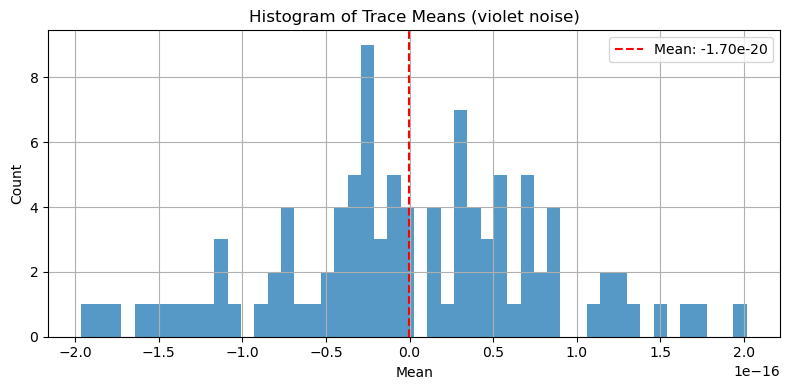


Analyzing: blue


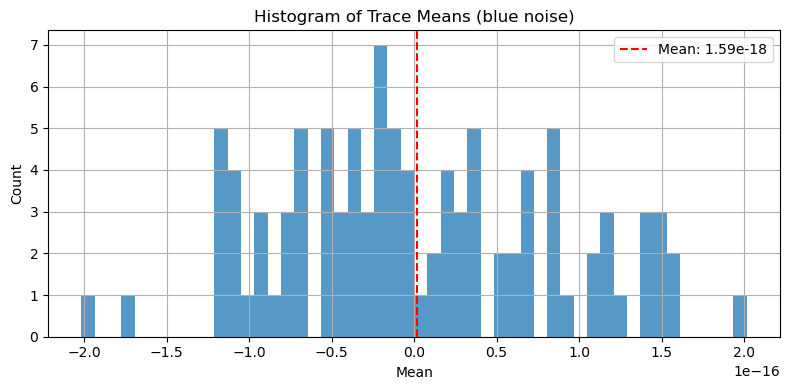


Analyzing: brownian


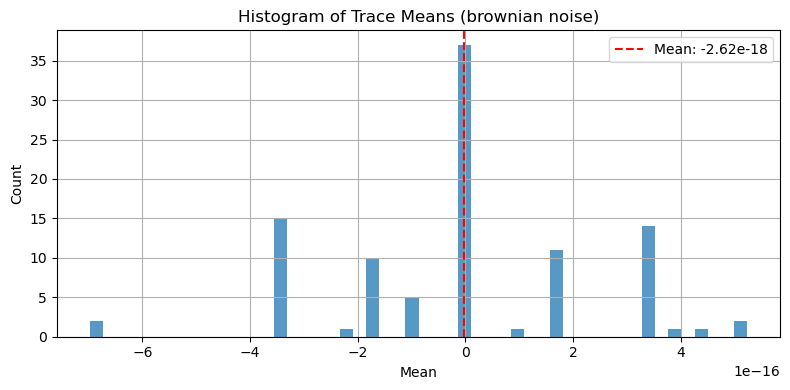


Analyzing: pink


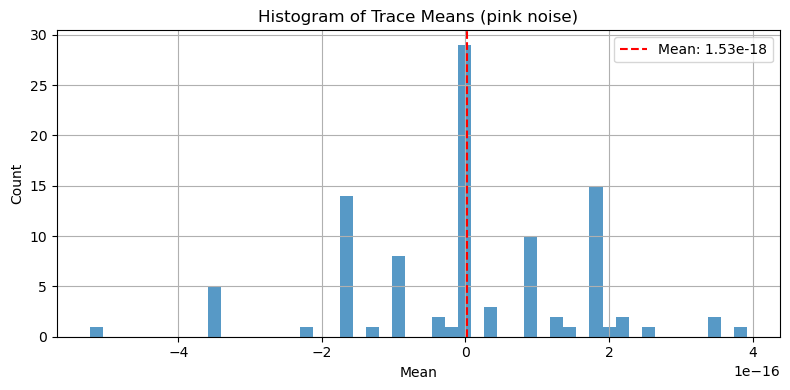

In [7]:
sampling_frequency = 3_906_250
trace_samples = 327
noise_power = 33
n_sets = 100

for noise_type in ['white', 'violet', 'blue', 'brownian', 'pink']:
    print(f"\nAnalyzing: {noise_type}")
    ng = NoiseGenerator(
        sampling_frequency,
        trace_samples,
        noise_power,
        noise_type=noise_type,
    )

    means = []
    for _ in range(n_sets):
        trace = ng.generate_noise()
        means.append(np.mean(trace))

    means = np.array(means)

    plt.figure(figsize=(8, 4))
    plt.hist(means, bins=50, alpha=0.75)
    plt.axvline(np.mean(means), color='red', linestyle='--', label=f"Mean: {np.mean(means):.2e}")
    plt.title(f"Histogram of Trace Means ({noise_type} noise)")
    plt.xlabel("Mean")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()